# In this Project we implement classification for CIFAR 10 dataset using deep learning methods and Local Binary Pattern.

### 1)  Implementing CIFAR10 using Deep Learning Methods

In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True
import os
from keras.datasets import cifar10

Using TensorFlow backend.


# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

 ship  doghorse shiphorseplane  dog


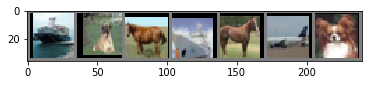

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# # show images
imshow(torchvision.utils.make_grid(images[0:7],nrow = 8))
# print labels
print(''.join('%5s' % classes[labels[j]] for j in range(7)))

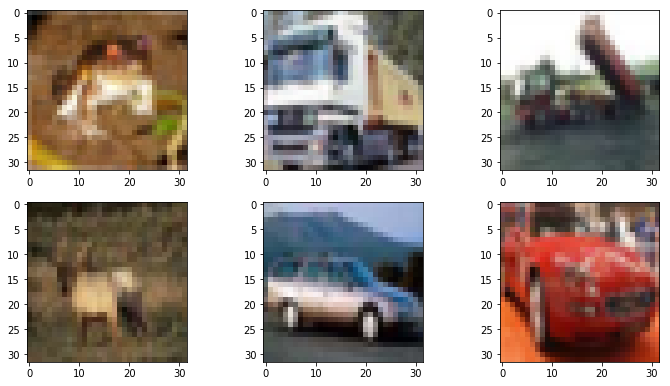

In [4]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. Later on I shifted to VGG networks which gave better accuracy. 
* After Implementing different VGG Networks, VGG13 gave the best results. 



In [40]:
# Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv = self._make_layers(config[vgg_name])
        self.linear = self._make_layers_linear()

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def vis(self, x):
        out = self.conv(x)
        return out
    
    def swish(self,x):
        return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

    def _make_layers(self, config):
        layers = []
        in_channels = 3
        for x in config:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
            elif x == 'D':
                layers+= [nn.Dropout(0.5)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
                                                                               # To presever spatial dimension. 
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]#inplace=True, PReLU()
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _make_layers_linear(self):
        layers = []
#         layers +=[nn.Linear(512, 256)]
#         layers+= [nn.Dropout(0.5)]
        layers += [nn.Linear(512, 10)]
#         layers += [nn.LogSoftmax(dim=1)]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers) # Try softmax here

net = VGG('VGG13')
# net = shufflenetv2
net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
torch.backends.cudnn.benchmark = True


In [41]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(3072, 1536)
#         self.relu1 = nn.ReLU()
#         self.dout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(1536, 384)
#         self.relu2 = nn.ReLU()
#         self.dout2 = nn.Dropout(0.2)
#         self.fc3 = nn.Linear(384, 64)
#         self.prelu = nn.PReLU(1)
#         self.out = nn.Linear(64, 10)
#         self.out_act = nn.LogSoftmax(dim =1)

#     def swish(self,x):
#         return x * torch.sigmoid(x)
        
#     def forward(self, input_):
#         inpu = input_.view(input_.size(0), -1)
#         x = self.fc1(inpu)
#         x = self.relu1(x)
#         x = self.dout(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.dout2(x)
#         x = self.fc3(x)
#         x = self.prelu(x)
#         y = self.out(x)
#         y = (self.out_act(x))
#         return y
# net = Net()
# net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)


In [42]:
net

DataParallel(
  (module): VGG(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [43]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           1,792
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
           Conv2d-12          [-1, 128, 16, 16]          73,856
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

## Explanations for Network Architecture

* The Loss function used is cross entropy class as there are multiple classes (10)
* The model architecture adopted was that of VGG 13. This is because: 
     * the accuracy was in the range of 64 – 71 percent with a 5 layer network (input – conv1 – conv2- linear - crossentropyloss) .
    * Convolutions were used as the input is 2D images. 
    * Even after adding dropouts of 0.2 and 0.5 in between the convolution layers the accuracy did not improve.
     * Conclusion: as the networks needs to learn RGB images and distinguish 10 labels, it will need more parameters to shatter the input space.  Also the images are very blurry, this adds on to the number of parameters needed as differentiating becomes more difficult.
* VGG 11 also did not give accuracies above 75 percent. As I was able to get descent accuracy with Vgg 13, I did not experiment with this network.
* The Optimizer with Vgg13 is taken as Adam, as it got me better accuracies than SGD. This may be because Adam is able to avoid local minima and does not get stuck. 
* Learning rate of 0.002 gets me a good error convergence graph. Increase the learning rate to 0.01 also gives similar results much faster, but then convergence graph is like a step function and therefore avoided.
* Some other experimentation with dropouts and different activations like (swish, relu and Prelu) can be seen in the screen shot of the excel file I made in the Ipython Notebook.

* Each filter or weights of the convolution layers is visualized, in the image shown below.
    * The image is a representation of weights of the first kernel in each layer (only a depth size of 3 is visualized for each convolution layer)
    * we can see that the weights initialized is different for each layer. ( as they have different colors).


## Visualizaing Weights

In [44]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0:3])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Showing the weights of the first kernel in each convolution layer
(64, 3, 3, 3)


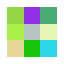

(64, 64, 3, 3)


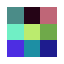

(128, 64, 3, 3)


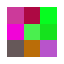

(128, 128, 3, 3)


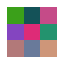

(256, 128, 3, 3)


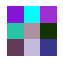

(256, 256, 3, 3)


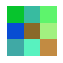

(512, 256, 3, 3)


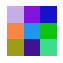

(512, 512, 3, 3)


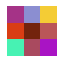

(512, 512, 3, 3)


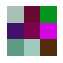

(512, 512, 3, 3)


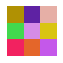

In [45]:
visnet = VGG('VGG13') #Net()
visnet = visnet.to('cpu').double()
print("Showing the weights of the first kernel in each convolution layer")
for m in visnet.modules():
    if isinstance(m, nn.Conv2d):   
        a = m.weight.data.numpy()
#         print(tensor.max())
        c = (a - np.min(a))/np.ptp(a).astype(float)
        print(c.shape)
        plot_kernels(c)
#         break


##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below or attached with homework sumission.
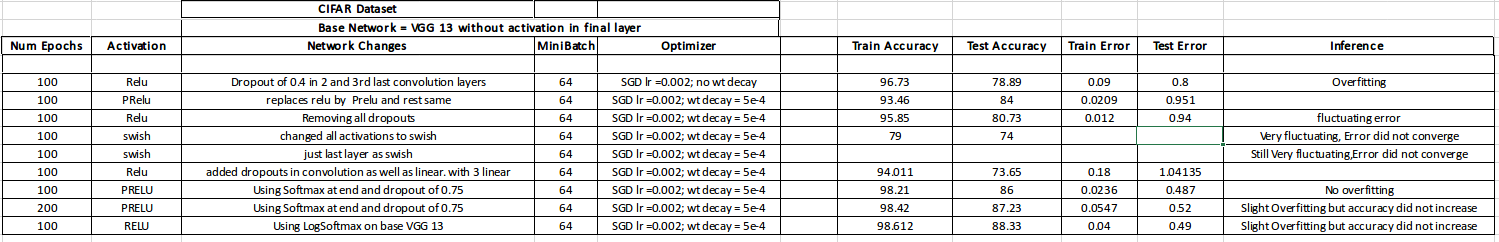
* After all the experimentation, the original vgg 13 network worked the best. Adding dropouts did not help, I guess this is due to not adding them at the right position. I also tried increasing the fully connected layers but it did not help.
* The most significant discrepancy was found that, when not using softmax layer or log softmax layer, the testing accuracy actually came out to be more. I dont know why this happened!!! 

In [46]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
# optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]
best_acc= 0  # best test accuracy


In [47]:
device

'cuda'

In [48]:
# # For Debugging
for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target)
#     loss.backward()
#     optimizer.step()
    break
# # target

In [49]:
data.view(data.size(0), -1).shape

torch.Size([128, 3072])

## Training and Testing Functions

In [50]:
def train(model, train_loader, optimizer, epoch,device):
#     print(criterion)
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    global best_acc
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Save checkpoint.
    acc = 100.*correct/len(test_loader.dataset)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'val_loss': val_loss,
            'test_accu': test_accu, 
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
    best_acc = acc

## Resume trained network if needed 

In [51]:
start_epoch = 0 # start from epoch 0 or last checkpoint epoch

# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [52]:
# a= net.state_dict(checkpoint['val_loss'])

# Training the Model

In [53]:
for epoch in range(start_epoch, 100):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.411667
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.064902
Train Epoch: 0 [5120/50000 (10%)]	Loss: 1.780800
Train Epoch: 0 [7680/50000 (15%)]	Loss: 1.730694
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.611837
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.707481
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.602357
Train Epoch: 0 [17920/50000 (36%)]	Loss: 1.507199
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.500497
Train Epoch: 0 [23040/50000 (46%)]	Loss: 1.515782
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.491078
Train Epoch: 0 [28160/50000 (56%)]	Loss: 1.528127
Train Epoch: 0 [30720/50000 (61%)]	Loss: 1.348028
Train Epoch: 0 [33280/50000 (66%)]	Loss: 1.397122
Train Epoch: 0 [35840/50000 (72%)]	Loss: 1.316757
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.322231
Train Epoch: 0 [40960/50000 (82%)]	Loss: 1.283389
Train Epoch: 0 [43520/50000 (87%)]	Loss: 1.212338
Train Epoch: 0 [46080/50000 (92%)]	Loss: 1.333481
Train Epoch: 0 [48640/50000 (97%)]	Loss: 1.133001

Test set

Train Epoch: 7 [40960/50000 (82%)]	Loss: 0.491802
Train Epoch: 7 [43520/50000 (87%)]	Loss: 0.533286
Train Epoch: 7 [46080/50000 (92%)]	Loss: 0.493269
Train Epoch: 7 [48640/50000 (97%)]	Loss: 0.517073

Test set: Average loss: 0.6458, Accuracy: 7781/10000 (78%)

Saving..
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.329256
Train Epoch: 8 [2560/50000 (5%)]	Loss: 0.484733
Train Epoch: 8 [5120/50000 (10%)]	Loss: 0.506566
Train Epoch: 8 [7680/50000 (15%)]	Loss: 0.464103
Train Epoch: 8 [10240/50000 (20%)]	Loss: 0.506845
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.525861
Train Epoch: 8 [15360/50000 (31%)]	Loss: 0.477643
Train Epoch: 8 [17920/50000 (36%)]	Loss: 0.425643
Train Epoch: 8 [20480/50000 (41%)]	Loss: 0.597369
Train Epoch: 8 [23040/50000 (46%)]	Loss: 0.465784
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.367813
Train Epoch: 8 [28160/50000 (56%)]	Loss: 0.577978
Train Epoch: 8 [30720/50000 (61%)]	Loss: 0.639502
Train Epoch: 8 [33280/50000 (66%)]	Loss: 0.474429
Train Epoch: 8 [35840/50000 (72%)]	Loss

Train Epoch: 15 [20480/50000 (41%)]	Loss: 0.487505
Train Epoch: 15 [23040/50000 (46%)]	Loss: 0.298825
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.455908
Train Epoch: 15 [28160/50000 (56%)]	Loss: 0.433878
Train Epoch: 15 [30720/50000 (61%)]	Loss: 0.379909
Train Epoch: 15 [33280/50000 (66%)]	Loss: 0.278055
Train Epoch: 15 [35840/50000 (72%)]	Loss: 0.451772
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.418073
Train Epoch: 15 [40960/50000 (82%)]	Loss: 0.325522
Train Epoch: 15 [43520/50000 (87%)]	Loss: 0.275331
Train Epoch: 15 [46080/50000 (92%)]	Loss: 0.274258
Train Epoch: 15 [48640/50000 (97%)]	Loss: 0.461228

Test set: Average loss: 0.5046, Accuracy: 8320/10000 (83%)

Saving..
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.371769
Train Epoch: 16 [2560/50000 (5%)]	Loss: 0.211620
Train Epoch: 16 [5120/50000 (10%)]	Loss: 0.323755
Train Epoch: 16 [7680/50000 (15%)]	Loss: 0.365226
Train Epoch: 16 [10240/50000 (20%)]	Loss: 0.273571
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.432466
Train Epoch: 16 [1536

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.221418
Train Epoch: 23 [2560/50000 (5%)]	Loss: 0.208005
Train Epoch: 23 [5120/50000 (10%)]	Loss: 0.180237
Train Epoch: 23 [7680/50000 (15%)]	Loss: 0.237541
Train Epoch: 23 [10240/50000 (20%)]	Loss: 0.205450
Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.174950
Train Epoch: 23 [15360/50000 (31%)]	Loss: 0.205256
Train Epoch: 23 [17920/50000 (36%)]	Loss: 0.204762
Train Epoch: 23 [20480/50000 (41%)]	Loss: 0.223738
Train Epoch: 23 [23040/50000 (46%)]	Loss: 0.347046
Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.411405
Train Epoch: 23 [28160/50000 (56%)]	Loss: 0.179615
Train Epoch: 23 [30720/50000 (61%)]	Loss: 0.204306
Train Epoch: 23 [33280/50000 (66%)]	Loss: 0.251375
Train Epoch: 23 [35840/50000 (72%)]	Loss: 0.322141
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.359161
Train Epoch: 23 [40960/50000 (82%)]	Loss: 0.211922
Train Epoch: 23 [43520/50000 (87%)]	Loss: 0.300145
Train Epoch: 23 [46080/50000 (92%)]	Loss: 0.284658
Train Epoch: 23 [48640/50000 (97%)]	Loss

Train Epoch: 30 [33280/50000 (66%)]	Loss: 0.223462
Train Epoch: 30 [35840/50000 (72%)]	Loss: 0.212402
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.216531
Train Epoch: 30 [40960/50000 (82%)]	Loss: 0.140373
Train Epoch: 30 [43520/50000 (87%)]	Loss: 0.220542
Train Epoch: 30 [46080/50000 (92%)]	Loss: 0.198395
Train Epoch: 30 [48640/50000 (97%)]	Loss: 0.109592

Test set: Average loss: 0.4795, Accuracy: 8486/10000 (85%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.410127
Train Epoch: 31 [2560/50000 (5%)]	Loss: 0.159696
Train Epoch: 31 [5120/50000 (10%)]	Loss: 0.143589
Train Epoch: 31 [7680/50000 (15%)]	Loss: 0.250492
Train Epoch: 31 [10240/50000 (20%)]	Loss: 0.205668
Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.279214
Train Epoch: 31 [15360/50000 (31%)]	Loss: 0.221231
Train Epoch: 31 [17920/50000 (36%)]	Loss: 0.130325
Train Epoch: 31 [20480/50000 (41%)]	Loss: 0.103786
Train Epoch: 31 [23040/50000 (46%)]	Loss: 0.193189
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.185228
Train Epoch: 31 [28160/50000 (

Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.092084
Train Epoch: 38 [15360/50000 (31%)]	Loss: 0.129882
Train Epoch: 38 [17920/50000 (36%)]	Loss: 0.104674
Train Epoch: 38 [20480/50000 (41%)]	Loss: 0.096444
Train Epoch: 38 [23040/50000 (46%)]	Loss: 0.158762
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.167088
Train Epoch: 38 [28160/50000 (56%)]	Loss: 0.150952
Train Epoch: 38 [30720/50000 (61%)]	Loss: 0.126974
Train Epoch: 38 [33280/50000 (66%)]	Loss: 0.151793
Train Epoch: 38 [35840/50000 (72%)]	Loss: 0.128756
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.155824
Train Epoch: 38 [40960/50000 (82%)]	Loss: 0.074511
Train Epoch: 38 [43520/50000 (87%)]	Loss: 0.165978
Train Epoch: 38 [46080/50000 (92%)]	Loss: 0.121784
Train Epoch: 38 [48640/50000 (97%)]	Loss: 0.107461

Test set: Average loss: 0.4658, Accuracy: 8576/10000 (86%)

Saving..
Train Epoch: 39 [0/50000 (0%)]	Loss: 0.157172
Train Epoch: 39 [2560/50000 (5%)]	Loss: 0.099458
Train Epoch: 39 [5120/50000 (10%)]	Loss: 0.082395
Train Epoch: 39 [768

Train Epoch: 45 [46080/50000 (92%)]	Loss: 0.100157
Train Epoch: 45 [48640/50000 (97%)]	Loss: 0.109468

Test set: Average loss: 0.4918, Accuracy: 8571/10000 (86%)

Train Epoch: 46 [0/50000 (0%)]	Loss: 0.092581
Train Epoch: 46 [2560/50000 (5%)]	Loss: 0.157480
Train Epoch: 46 [5120/50000 (10%)]	Loss: 0.138213
Train Epoch: 46 [7680/50000 (15%)]	Loss: 0.119344
Train Epoch: 46 [10240/50000 (20%)]	Loss: 0.163695
Train Epoch: 46 [12800/50000 (26%)]	Loss: 0.126577
Train Epoch: 46 [15360/50000 (31%)]	Loss: 0.079702
Train Epoch: 46 [17920/50000 (36%)]	Loss: 0.147835
Train Epoch: 46 [20480/50000 (41%)]	Loss: 0.162198
Train Epoch: 46 [23040/50000 (46%)]	Loss: 0.144980
Train Epoch: 46 [25600/50000 (51%)]	Loss: 0.136137
Train Epoch: 46 [28160/50000 (56%)]	Loss: 0.241200
Train Epoch: 46 [30720/50000 (61%)]	Loss: 0.090766
Train Epoch: 46 [33280/50000 (66%)]	Loss: 0.152235
Train Epoch: 46 [35840/50000 (72%)]	Loss: 0.107663
Train Epoch: 46 [38400/50000 (77%)]	Loss: 0.108319
Train Epoch: 46 [40960/50000 (

Train Epoch: 53 [25600/50000 (51%)]	Loss: 0.043034
Train Epoch: 53 [28160/50000 (56%)]	Loss: 0.182788
Train Epoch: 53 [30720/50000 (61%)]	Loss: 0.089997
Train Epoch: 53 [33280/50000 (66%)]	Loss: 0.132471
Train Epoch: 53 [35840/50000 (72%)]	Loss: 0.110467
Train Epoch: 53 [38400/50000 (77%)]	Loss: 0.116779
Train Epoch: 53 [40960/50000 (82%)]	Loss: 0.066182
Train Epoch: 53 [43520/50000 (87%)]	Loss: 0.191933
Train Epoch: 53 [46080/50000 (92%)]	Loss: 0.084372
Train Epoch: 53 [48640/50000 (97%)]	Loss: 0.062881

Test set: Average loss: 0.4811, Accuracy: 8658/10000 (87%)

Saving..
Train Epoch: 54 [0/50000 (0%)]	Loss: 0.079857
Train Epoch: 54 [2560/50000 (5%)]	Loss: 0.050686
Train Epoch: 54 [5120/50000 (10%)]	Loss: 0.153972
Train Epoch: 54 [7680/50000 (15%)]	Loss: 0.092890
Train Epoch: 54 [10240/50000 (20%)]	Loss: 0.079081
Train Epoch: 54 [12800/50000 (26%)]	Loss: 0.075616
Train Epoch: 54 [15360/50000 (31%)]	Loss: 0.084041
Train Epoch: 54 [17920/50000 (36%)]	Loss: 0.056645
Train Epoch: 54 [2048

Train Epoch: 61 [5120/50000 (10%)]	Loss: 0.077659
Train Epoch: 61 [7680/50000 (15%)]	Loss: 0.098953
Train Epoch: 61 [10240/50000 (20%)]	Loss: 0.031136
Train Epoch: 61 [12800/50000 (26%)]	Loss: 0.071351
Train Epoch: 61 [15360/50000 (31%)]	Loss: 0.033852
Train Epoch: 61 [17920/50000 (36%)]	Loss: 0.113380
Train Epoch: 61 [20480/50000 (41%)]	Loss: 0.069756
Train Epoch: 61 [23040/50000 (46%)]	Loss: 0.079950
Train Epoch: 61 [25600/50000 (51%)]	Loss: 0.104368
Train Epoch: 61 [28160/50000 (56%)]	Loss: 0.065409
Train Epoch: 61 [30720/50000 (61%)]	Loss: 0.080579
Train Epoch: 61 [33280/50000 (66%)]	Loss: 0.078952
Train Epoch: 61 [35840/50000 (72%)]	Loss: 0.096966
Train Epoch: 61 [38400/50000 (77%)]	Loss: 0.033146
Train Epoch: 61 [40960/50000 (82%)]	Loss: 0.102640
Train Epoch: 61 [43520/50000 (87%)]	Loss: 0.054524
Train Epoch: 61 [46080/50000 (92%)]	Loss: 0.068059
Train Epoch: 61 [48640/50000 (97%)]	Loss: 0.103552

Test set: Average loss: 0.4760, Accuracy: 8729/10000 (87%)

Saving..
Train Epoch: 6

Train Epoch: 68 [40960/50000 (82%)]	Loss: 0.100556
Train Epoch: 68 [43520/50000 (87%)]	Loss: 0.062589
Train Epoch: 68 [46080/50000 (92%)]	Loss: 0.138354
Train Epoch: 68 [48640/50000 (97%)]	Loss: 0.042869

Test set: Average loss: 0.4971, Accuracy: 8695/10000 (87%)

Saving..
Train Epoch: 69 [0/50000 (0%)]	Loss: 0.034036
Train Epoch: 69 [2560/50000 (5%)]	Loss: 0.029561
Train Epoch: 69 [5120/50000 (10%)]	Loss: 0.086008
Train Epoch: 69 [7680/50000 (15%)]	Loss: 0.062459
Train Epoch: 69 [10240/50000 (20%)]	Loss: 0.060477
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.063126
Train Epoch: 69 [15360/50000 (31%)]	Loss: 0.016271
Train Epoch: 69 [17920/50000 (36%)]	Loss: 0.068278
Train Epoch: 69 [20480/50000 (41%)]	Loss: 0.062965
Train Epoch: 69 [23040/50000 (46%)]	Loss: 0.097516
Train Epoch: 69 [25600/50000 (51%)]	Loss: 0.104160
Train Epoch: 69 [28160/50000 (56%)]	Loss: 0.062328
Train Epoch: 69 [30720/50000 (61%)]	Loss: 0.053020
Train Epoch: 69 [33280/50000 (66%)]	Loss: 0.040569
Train Epoch: 69 [3584

Train Epoch: 76 [20480/50000 (41%)]	Loss: 0.051105
Train Epoch: 76 [23040/50000 (46%)]	Loss: 0.043488
Train Epoch: 76 [25600/50000 (51%)]	Loss: 0.012709
Train Epoch: 76 [28160/50000 (56%)]	Loss: 0.072166
Train Epoch: 76 [30720/50000 (61%)]	Loss: 0.117934
Train Epoch: 76 [33280/50000 (66%)]	Loss: 0.075956
Train Epoch: 76 [35840/50000 (72%)]	Loss: 0.086409
Train Epoch: 76 [38400/50000 (77%)]	Loss: 0.077471
Train Epoch: 76 [40960/50000 (82%)]	Loss: 0.023900
Train Epoch: 76 [43520/50000 (87%)]	Loss: 0.035381
Train Epoch: 76 [46080/50000 (92%)]	Loss: 0.035963
Train Epoch: 76 [48640/50000 (97%)]	Loss: 0.031087

Test set: Average loss: 0.5052, Accuracy: 8731/10000 (87%)

Saving..
Train Epoch: 77 [0/50000 (0%)]	Loss: 0.036522
Train Epoch: 77 [2560/50000 (5%)]	Loss: 0.029762
Train Epoch: 77 [5120/50000 (10%)]	Loss: 0.094489
Train Epoch: 77 [7680/50000 (15%)]	Loss: 0.034284
Train Epoch: 77 [10240/50000 (20%)]	Loss: 0.035070
Train Epoch: 77 [12800/50000 (26%)]	Loss: 0.046234
Train Epoch: 77 [1536

Train Epoch: 84 [0/50000 (0%)]	Loss: 0.046356
Train Epoch: 84 [2560/50000 (5%)]	Loss: 0.077547
Train Epoch: 84 [5120/50000 (10%)]	Loss: 0.017984
Train Epoch: 84 [7680/50000 (15%)]	Loss: 0.068962
Train Epoch: 84 [10240/50000 (20%)]	Loss: 0.026910
Train Epoch: 84 [12800/50000 (26%)]	Loss: 0.030836
Train Epoch: 84 [15360/50000 (31%)]	Loss: 0.113017
Train Epoch: 84 [17920/50000 (36%)]	Loss: 0.033481
Train Epoch: 84 [20480/50000 (41%)]	Loss: 0.082823
Train Epoch: 84 [23040/50000 (46%)]	Loss: 0.024592
Train Epoch: 84 [25600/50000 (51%)]	Loss: 0.018785
Train Epoch: 84 [28160/50000 (56%)]	Loss: 0.068636
Train Epoch: 84 [30720/50000 (61%)]	Loss: 0.085251
Train Epoch: 84 [33280/50000 (66%)]	Loss: 0.075491
Train Epoch: 84 [35840/50000 (72%)]	Loss: 0.020330
Train Epoch: 84 [38400/50000 (77%)]	Loss: 0.055324
Train Epoch: 84 [40960/50000 (82%)]	Loss: 0.051913
Train Epoch: 84 [43520/50000 (87%)]	Loss: 0.093614
Train Epoch: 84 [46080/50000 (92%)]	Loss: 0.024958
Train Epoch: 84 [48640/50000 (97%)]	Loss

Train Epoch: 91 [33280/50000 (66%)]	Loss: 0.038129
Train Epoch: 91 [35840/50000 (72%)]	Loss: 0.061331
Train Epoch: 91 [38400/50000 (77%)]	Loss: 0.047679
Train Epoch: 91 [40960/50000 (82%)]	Loss: 0.062221
Train Epoch: 91 [43520/50000 (87%)]	Loss: 0.025671
Train Epoch: 91 [46080/50000 (92%)]	Loss: 0.024681
Train Epoch: 91 [48640/50000 (97%)]	Loss: 0.042918

Test set: Average loss: 0.4885, Accuracy: 8800/10000 (88%)

Train Epoch: 92 [0/50000 (0%)]	Loss: 0.021218
Train Epoch: 92 [2560/50000 (5%)]	Loss: 0.042951
Train Epoch: 92 [5120/50000 (10%)]	Loss: 0.051941
Train Epoch: 92 [7680/50000 (15%)]	Loss: 0.033161
Train Epoch: 92 [10240/50000 (20%)]	Loss: 0.031995
Train Epoch: 92 [12800/50000 (26%)]	Loss: 0.071371
Train Epoch: 92 [15360/50000 (31%)]	Loss: 0.023832
Train Epoch: 92 [17920/50000 (36%)]	Loss: 0.044241
Train Epoch: 92 [20480/50000 (41%)]	Loss: 0.025266
Train Epoch: 92 [23040/50000 (46%)]	Loss: 0.037417
Train Epoch: 92 [25600/50000 (51%)]	Loss: 0.070474
Train Epoch: 92 [28160/50000 (

Train Epoch: 99 [12800/50000 (26%)]	Loss: 0.046352
Train Epoch: 99 [15360/50000 (31%)]	Loss: 0.029037
Train Epoch: 99 [17920/50000 (36%)]	Loss: 0.022551
Train Epoch: 99 [20480/50000 (41%)]	Loss: 0.031419
Train Epoch: 99 [23040/50000 (46%)]	Loss: 0.008202
Train Epoch: 99 [25600/50000 (51%)]	Loss: 0.032484
Train Epoch: 99 [28160/50000 (56%)]	Loss: 0.063834
Train Epoch: 99 [30720/50000 (61%)]	Loss: 0.020989
Train Epoch: 99 [33280/50000 (66%)]	Loss: 0.076312
Train Epoch: 99 [35840/50000 (72%)]	Loss: 0.040706
Train Epoch: 99 [38400/50000 (77%)]	Loss: 0.069775
Train Epoch: 99 [40960/50000 (82%)]	Loss: 0.031469
Train Epoch: 99 [43520/50000 (87%)]	Loss: 0.081212
Train Epoch: 99 [46080/50000 (92%)]	Loss: 0.010633
Train Epoch: 99 [48640/50000 (97%)]	Loss: 0.040938

Test set: Average loss: 0.4990, Accuracy: 8771/10000 (88%)



## Resume trained network

In [54]:
# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [55]:
start_epoch

0

Training Loss: 0.04209168455885042
Training Accuracy: 98.524

Test Loss: 0.5215274107024074
Testing Accuracy: 88.15



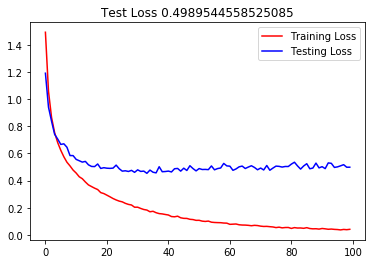

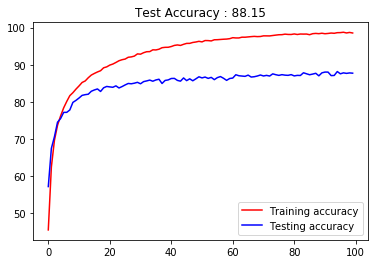

In [56]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', np.max(test_accu))
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(test_accu)))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

# Incorrect Predictions


In [22]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
classlabels = ['airplane', 'automobile', 'bird', 'cat' , 'deer' , 'dog', 'frog', 'horse', 'ship', 'truck']
n = 6   # Number of False predictions to output

vis_loader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)


# vis_loader = torch.utils.data.DataLoader(
#     FlowerLoader(x_test, y_test, transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         normalize,
#     ])), shuffle=False)

for data, target in vis_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    


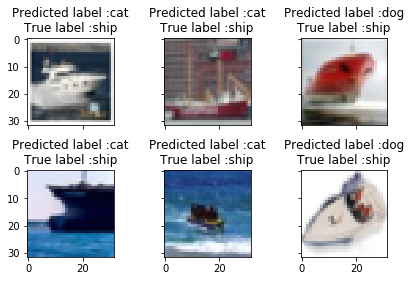

In [23]:
#======= Plotting Incorrect=======
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictedlabel[maxerrorind[num]]],
                                                                              classlabels[targetlabel[maxerrorind[num]]]))
        num = num+1
fig.tight_layout()

## Correct Predictions

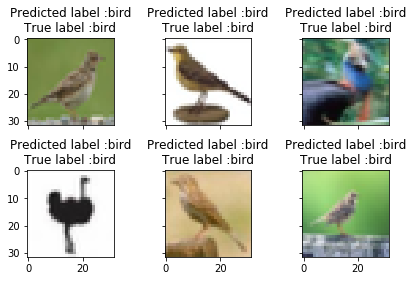

In [24]:
#======= Plotting Correct=======

ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num =  0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictedlabel[maxerrorind[num]]],
                                                                               classlabels[targetlabel[maxerrorind[num]]]))
        num = num + 1
fig.tight_layout()

### 2) Implementing using Local Binary Pattern

In [59]:
from skimage import feature
from matplotlib import pyplot as plt

import numpy as np
from sklearn.svm import LinearSVC  
from imutils import paths
import argparse
import cv2
from keras.datasets import cifar10


In [60]:
numPoints = 24
radius = 8
def describe(image, eps=1e-7):
# compute the Local Binary Pattern representation
# of the image, and then use the LBP representation
# to build the histogram of patterns
    lbp = feature.local_binary_pattern(image,numPoints,radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2)) 
# # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    # return the histogram of Local Binary Patterns
    return hist

In [17]:
data = []
labels = []
for i in range(0,x_train.shape[0]):
    img = x_train[i]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = describe(gray)
    labels.append(y_train[i])
    data.append(hist)
#     print(hist.shape)
#     break
# np.save('train_data.npy',data)
# np.save('train_label.npy',labels)    

In [62]:
# train a Linear SVM on the data
data = np.load('train_data.npy')
labels = np.load('train_label.npy')   
svclassifier = LinearSVC()  
h = svclassifier.fit(data, labels.ravel())  

In [64]:
acc = [] 
# loop over the testing images
for i in range(0,x_train.shape[0]):
    img = x_train[i]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = describe(gray)
    prediction = h.predict(hist.reshape(1, -1))
    acc.append(prediction == y_train[i])

In [24]:
np.mean(acc)


0.2342

In [25]:
np.sum(acc*1)

2342